In [1]:
import sys
sys.path.append('../')

import os

import cqt
import cqt.env.mkt_env as env 
import cqt.env.mkt_env_spot as envspot
import cqt.ledger.ledger as ledger
import cqt.datagen as dg
import cqt.dbutility.dbutility as db
import cqt.strats.strategy as stg
import cqt.strats.strategy_long_short_average as stg_ls
import pandas as pd
import pickle

from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import copy
import cqt.strats.StrategyTensorFlow as stg_tf

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
### db.get_table_list() method takes 1 argument db_id, and is defaulted to 'Amazon_RDS'
df_tbl_list=db.get_table_list()
print(df_tbl_list)

In [3]:
TODAY = datetime.now()


In [ ]:
print(TODAY)

In [4]:
tbl_name='coinapi-ohlcv-COINBASE_SPOT_BTC_USD-1HRS'
df_btc=db.get_from_db(tbl_name,from_date='2016-01-01',to_date=TODAY.strftime('%Y-%M-%d'))
#df_eth = db.get_from_db("coinapi-ohlcv-COINBASE_SPOT_ETH_USD-1DAY",from_date='2016-01-01',to_date=TODAY.strftime('%Y-%M-%d'))

/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [ ]:
df_btc.data

In [5]:
config = {'asset_type': 'spot'}
model_btc_eth = env.MktEnv([])
comp_btc = envspot.MktEnvSpot('btc', df_btc.get_index_data(), config)
model_btc_eth.insert_section(comp_btc)



cash = 10000
assets = {'btc': 0}
ini_pfo = ledger.Ledger(assets, cash)


In [ ]:
# Long/Short Average
ls_rule = {'method' : 'moving_average', 'window_size' : [3, 5], 'tolerance_up' : 0.03, 'tolerance_down' : 0.03}
strats = stg_ls.StrategyInverseMA(model_btc_eth, ini_pfo, ls_rule)
start_date_str = '2017-01-01'
start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
report = strats.back_testing(start_date,datetime.strptime('2018-01-01', '%Y-%m-%d'))

longShortReport = report.copy()

In [ ]:
longShortReport

In [ ]:
report = longShortReport
outDir='./'

strategyName = '2017-2018 Inverse Long Short Average HRS[3, 5] (0.03, 0.03)'
report.to_csv(os.path.join(outDir, strategyName+'.csv'), index=False)
fig_width = 12
fig_height = 12
fig, ax0 = plt.subplots(2,1, figsize=(fig_width,fig_height))
ax0[0].plot(report['date'], report['total'])
ax0[0].plot(report['date'], report['btc_price'] * cash / report['btc_price'][0])
ax0[0].set_title('portfolio performance')
ax0[1].plot(report['date'], report['pnl'])
ax0[1].set_title('daily pnl')
fig.suptitle(strategyName)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.savefig(os.path.join(outDir, strategyName+'.pdf'))
plt.show()

print('max daily gain:', report['pnl'].max())
print('max daily loss:', report['pnl'].min())


In [ ]:
import cqt.strats.strategy_double_dip as stg_dd

# Double Dip Strategy
dd_rule = {'method' : 'moving_average', 'window_size' : [3, 5], 'tolerance_up' : 0.03, 'tolerance_down' : 0.03}
strats = stg_dd.StrategyDoubleDip(model_btc_eth, ini_pfo, dd_rule)
report = strats.back_testing(datetime.strptime('2016-01-10', '%Y-%m-%d'),datetime.strptime('2017-01-01', '%Y-%m-%d'))

In [ ]:
report[-10:]

In [ ]:
outDir='./'
strategyName = '2016-2017 Double Tops Bottoms HRS [3, 5] (0.03, 0.03)'
report.to_csv(os.path.join(outDir, strategyName+'.csv'), index=False)
fig_width = 12
fig_height = 12
fig, ax0 = plt.subplots(2,1, figsize=(fig_width,fig_height))
ax0[0].plot(report['date'], report['total'])
ax0[0].plot(report['date'], report['btc_price'] * cash / report['btc_price'][0])
ax0[0].set_title('portfolio performance')
ax0[1].plot(report['date'], report['pnl'])
ax0[1].set_title('daily pnl')
fig.suptitle(strategyName)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.savefig(os.path.join(outDir, strategyName+'.pdf'))
plt.show()

print('max daily gain:', report['pnl'].max())
print('max daily loss:', report['pnl'].min())

In [ ]:
report[-100:]


In [ ]:
from talib.abstract import *
import copy
prices = copy.deepcopy(comp_btc.data)

In [ ]:
prices[-10:]

In [ ]:
prices.rename(columns={'price_open': 'open', 'price_high': 'high', 'price_low': 'low', 'price_close': 'close', 'volume_traded': 'volume'}, inplace=True)
close = prices['close'].values
sma15 = SMA(prices, timeperiod=15)
sma60 = SMA(prices, timeperiod=60)
rsi = RSI(prices, timeperiod=14)
atr = ATR(prices, timeperiod=14)

In [ ]:
import numpy
import talib

close = prices['close'].values

from talib import MA_Type

upper, middle, lower = talib.BBANDS(close, matype=MA_Type.T3)


In [ ]:
fig_width = 15
fig_height = 6
fig, ax0 = plt.subplots(1,1, figsize=(fig_width,fig_height))
ax0.plot(prices.index[-300:],close[-300:],  'r-*',prices.index[-300:],upper[-300:],'b--',prices.index[-300:],middle[-300:], 'y--', prices.index[-300:],lower[-300:], 'g--')
plt.show()

In [ ]:
fig_width = 15
fig_height = 6
fig, ax0 = plt.subplots(1,1, figsize=(fig_width,fig_height))
ax0.plot(close[-300:],  'r-*',upper[-300:],'b--',middle[-300:], 'y--', lower[-300:], 'g--')
plt.show()

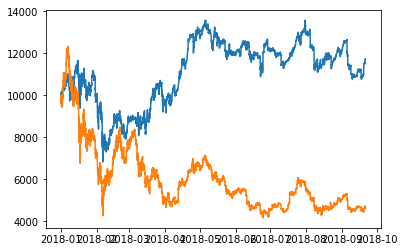

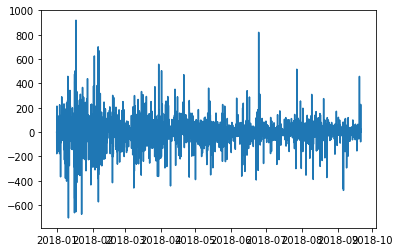

In [12]:
import cqt.strats.StrategyBBANDS as stg_bb

# B BANDS Strategy
bb_rule = {'method' : 'moving_average', 'timeperiod' :5, 'nbdevup' : 1.2, 'nbdevdn' : 1.2}
strats = stg_bb.StrategyBBANDS(model_btc_eth, ini_pfo, bb_rule)
report = strats.back_testing(datetime.strptime('2018-01-01', '%Y-%m-%d'),TODAY)

In [ ]:
plt.plot(report['date'],report['total'])

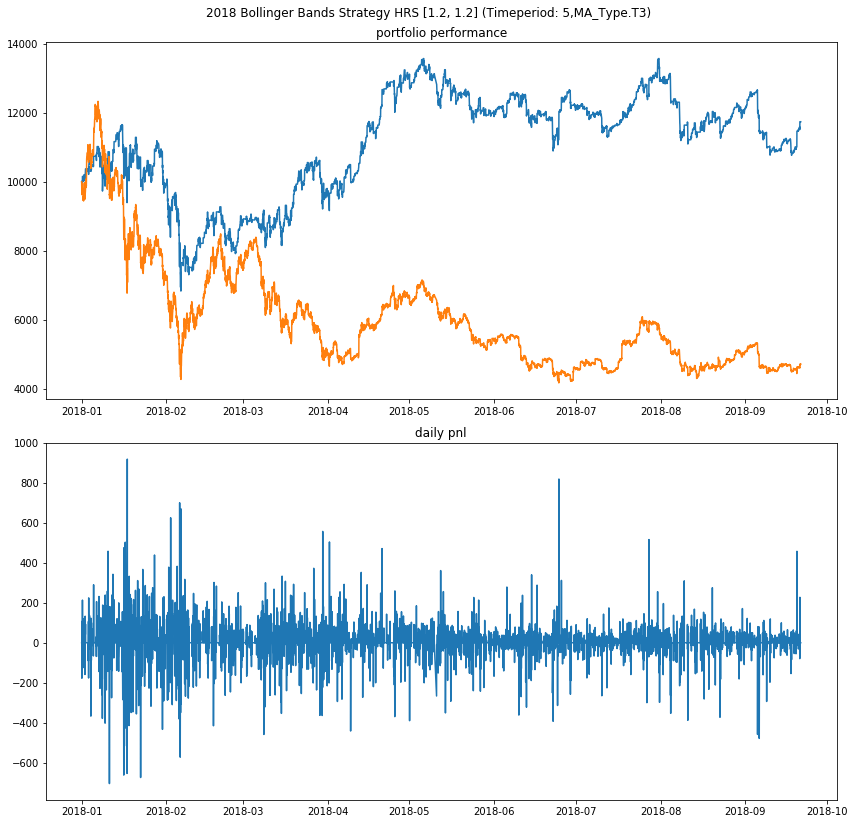

max daily gain: 918.9614104119028
max daily loss: -704.8969950262635


In [13]:
outDir='./'
strategyName = '2018 Bollinger Bands Strategy HRS [1.2, 1.2] (Timeperiod: 5,MA_Type.T3)'
report.to_csv(os.path.join(outDir, strategyName+'.csv'), index=False)
fig_width = 12
fig_height = 12
fig, ax0 = plt.subplots(2,1, figsize=(fig_width,fig_height))
ax0[0].plot(report['date'], report['total'])
ax0[0].plot(report['date'], report['btc_price'] * cash / report['btc_price'][0])
ax0[0].set_title('portfolio performance')
ax0[1].plot(report['date'], report['pnl'])
ax0[1].set_title('daily pnl')
fig.suptitle(strategyName)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.savefig(os.path.join(outDir, strategyName+'.pdf'))
plt.show()

print('max daily gain:', report['pnl'].max())
print('max daily loss:', report['pnl'].min())


In [ ]:
report[-10:]

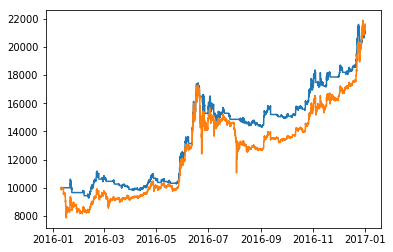

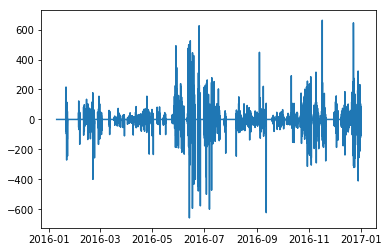

In [14]:
import cqt.strats.StrategyRSI as stg_rsi

# RSI Strategy
rsi_rule = {'method' : 'RSI','band':[30,70]}
strats = stg_rsi.StrategyRSI(model_btc_eth, ini_pfo, rsi_rule)
report = strats.back_testing(datetime.strptime('2016-01-10', '%Y-%m-%d'),datetime.strptime('2017-01-01', '%Y-%m-%d'))

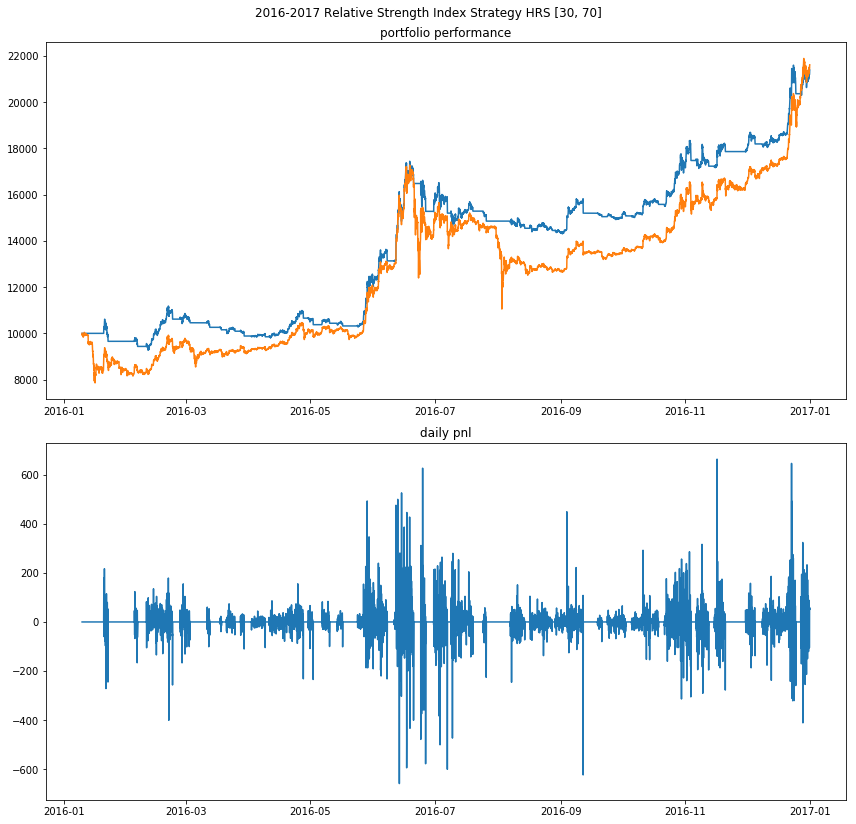

max daily gain: 662.5922615213494
max daily loss: -657.7506579286201


In [15]:
strategyName = '2016-2017 Relative Strength Index Strategy HRS [30, 70]'
report.to_csv(os.path.join(outDir, strategyName+'.csv'), index=False)
fig_width = 12
fig_height = 12
fig, ax0 = plt.subplots(2,1, figsize=(fig_width,fig_height))
ax0[0].plot(report['date'], report['total'])
ax0[0].plot(report['date'], report['btc_price'] * cash / report['btc_price'][0])
ax0[0].set_title('portfolio performance')
ax0[1].plot(report['date'], report['pnl'])
ax0[1].set_title('daily pnl')
fig.suptitle(strategyName)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.savefig(os.path.join(outDir, strategyName+'.pdf'))
plt.show()

print('max daily gain:', report['pnl'].max())
print('max daily loss:', report['pnl'].min())

In [ ]:
report[-10:]

In [ ]:
import cqt.strats.StrategyATR as stg_atr

# ATR Strategy
atr_rule = {'method' : 'ATR','bandwidth':[-1,1],'timeperiod':[8,8]}
strats = stg_atr.StrategyATR(model_btc_eth, ini_pfo, atr_rule)
report = strats.back_testing(datetime.strptime('2017-01-01', '%Y-%m-%d'),datetime.strptime('2018-01-01', '%Y-%m-%d'))

In [ ]:
outDir='./'
strategyName = '2017-2018 ATR Strategy HRS bound [-1, 1],window [8,8]'
report.to_csv(os.path.join(outDir, strategyName+'.csv'), index=False)
fig_width = 12
fig_height = 12
fig, ax0 = plt.subplots(2,1, figsize=(fig_width,fig_height))
ax0[0].plot(report['date'], report['total'])
ax0[0].plot(report['date'], report['btc_price'] * cash / report['btc_price'][0])
ax0[0].set_title('portfolio performance')
ax0[1].plot(report['date'], report['pnl'])
ax0[1].set_title('daily pnl')
fig.suptitle(strategyName)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.savefig(os.path.join(outDir, strategyName+'.pdf'))
plt.show()

print('max daily gain:', report['pnl'].max())
print('max daily loss:', report['pnl'].min())